<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 7th exercise: <font color="#C70039">Work with Variational Autoencoders (Generative Model)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   08.08.2023

<img src="https://miro.medium.com/max/848/1*6uuK7GpIbfTb-0chqFwXXw.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
A Variational Autoencoder (VAE), instead of compressing its input image into a fixed code in the latent space (as the classic autoencoder does), turns the input image into the parameters of a statistical distribution: a mean and a variance.

This implies / imputes that the input image has been generated by a statistical process and that the randomness of this process should be taken into accounting during encoding and decoding. 

The VAE then uses the mean and variance parameters to randomly sample one element of that distribution, and decodes that element back to the original input. 

The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.


---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
    * try to understand each single step.
4. the notebooks code, especially keras is sometimes utilized a bit cumbersome. Try to optimize the code where you feel necessary.
5. experiment with different hyperparameters (search for the keyword 'task')
6. describe the three different loss curve plots. What do they show? Is this what you expected?
7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).
8. describe the latent space with respect to its structure. Is this what you expected from a VAE?
---------------------------------

### VAEs
This code demonstrates a VAE using the MNIST dataset.
Just like a regular autoencoder a VAE returns an array (image) of same dimensions as the input but variation can be introduced by tweaking the so-called latent vector.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist

### Model: "Encoder"
Create an encoder model with the following properties:


In [2]:
# _____________________________________________________________________________
#  Layer (type)                 Output Shape         Activation     Input      
# =============================================================================
#  encoder_input (InputLayer)       [(None, 28, 28, 1)]  None           
#  encoder_flatten (Flatten)        (None, 784)          None           enc_input
#  encoder_dense_1 (Dense)          (None, 2000)         ReLU           enc_flatten
#  encoder_dense_2 (Dense)          (None, 256)          ReLU           enc_dense_1
#  z_mean (Dense)                   (None, 2)            None           enc_dense_2
#  z_log_var (Dense)                (None, 2)            None           enc_dense_2

encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)
z_mean = layers.Dense(units = 2, name = 'latent_mean')(encoder_dense_2)
z_log_var  = layers.Dense(units = 2, name = 'latent_log_var')(encoder_dense_2)

encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 flat (Flatten)              (None, 784)                  0         ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 2000)                 1570000   ['flat[0][0]']                
                                                                                                  
 dense_2 (Dense)             (None, 256)                  512256    ['dense_1[0][0]']             
                                                                                            

### Model: "decoder"
Create a decoder model with the following properties:

In [3]:
# _____________________________________________________________________________
#  Layer (type)                Output Shape          Activation     Input
# =============================================================================
#  decoder_input (InputLayer)      [(None, 2)]           None
#  decoder_dense_1 (Dense)         (None, 256)           ReLU           dec_input
#  decoder_dense_2 (Dense)         (None, 2000)          ReLU           dec_dense_1
#  decoder_dense_3 (Dense)         (None, 784)           Sigmoid        dec_dense_2
#  img_out (Reshape)               (None, 28, 28, 1)     None           des_dense_3

decoder_input = layers.Input(shape=(2,), dtype='float32')
decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dec_dense_1 (Dense)         (None, 256)               768       
                                                                 
 dec_dense_2 (Dense)         (None, 2000)              514000    
                                                                 
 dec_dense_3 (Dense)         (None, 784)               1568784   
                                                                 
 img_out (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 2083552 (7.95 MB)
Trainable params: 2083552 (7.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# class 'latent_sampling', which subclasses layers.Layer.
# The class should perform the reparameterisation trick in its .call() method.

'''---------------------------------------------------------------------------'''
# Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
# epsilon = N(0,1), a unit normal with same dims as mean and variance
'''---------------------------------------------------------------------------'''
class latent_sampling(layers.Layer):
    
  def call(self, z_mean, z_log_var):
    tf.keras.layers.Layer(trainable = True)
    self.batch = tf.shape(z_mean)[0]
    self.dim = tf.shape(z_mean)[1]
    self.epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
    self.z =  z_mean + self.epsilon * tf.exp(z_log_var * 0.5)
    
    return self.z

In [5]:
### The 'VAE' Class. 
### The __init__ method—which will set up the layers and submodels—and the call() method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim, encoder, decoder):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        self.latent_dim = latent_dim
        self.encoder = encoder
        self.sampling = latent_sampling()
        self.decoder = decoder
        
    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        x_hat = self.decoder(z)
        return x_hat

    def kl_loss(self, mean, logvar):
        """
        Method that calculates the Kullback-Liebler divergence between the
        posterier distribution, N(mean, variance), and the prior, N(0,1).
        Can be added to the model as a loss or metric, using self.add_loss and
        self.add_metric
        """

        # Calculate the element wise KL divergence
        kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        # Sum up the divergence of all the variables in each data sample
        kl = tf.reduce_sum(kl, axis=1)
        # Average the divergence across all samples in the batch
        kl = tf.reduce_mean(kl)
        return kl

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. Add
        the kl divergence to the model losses and metrics. Return the generated
        image.
        """
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        self.add_metric(self.kl_loss(z_mean, z_log_var), name = 'kl_loss_metric')
        return output

In [6]:
# Modified loss function for the model. The standard binary cross entropy
# takes a mean over all pixels in all images, but the VAE needs the
# reconstruction loss to be the sum of the pixel-wise losses, averaged over
# samples in the batch. Otherwise the reconstruction loss is becoming too small.

def recon_loss(y_true, y_pred):
    loss = tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred),axis=(1, 2))
    return loss

In [7]:
# Create the VAE model, using your encoder and decoder models. 
# Compile the model with appropriate optimizer settings, losses and metrics.
'''
(TASK: don't be afraid to experiment with different settings here (e.g. latent_dim))
'''
autoencoder = VAE(latent_dim = 2, encoder = encoder, decoder = decoder)

# Default learning rate, optimizer = nAdam.
autoencoder.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,
                    metrics = [recon_loss, 'accuracy'])

In [8]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Function to preprocess the data 
def preprocessing(image):
    image =  tf.expand_dims(image, -1)
    image =  tf.image.random_flip_left_right(image)
    image  = tf.image.convert_image_dtype(image, 'float32')

    return image, image

# Slice off the training data
dataset = tf.data.Dataset.from_tensor_slices(x_train)

# Preparing the data for training 
final_dataset = dataset.shuffle(1000).batch(64, drop_remainder=True).map(preprocessing)

### Train the model
Train the model on the images from the training set until the losses converge.
"history = model.fit" allows for storing the training and validation losses in a dictionary so they can be visualized later.

In [9]:
history = autoencoder.fit(final_dataset, batch_size = 256, epochs =30)
history.history.keys()  

Epoch 1/30
937/937 [==============================] - 163s 155ms/step - loss: 177.8545 - recon_loss: 172.7988 - accuracy: 0.7934 - kl_loss_metric: 5.0555
Epoch 2/30
937/937 [==============================] - 136s 146ms/step - loss: 163.9584 - recon_loss: 158.5421 - accuracy: 0.7941 - kl_loss_metric: 5.4162
Epoch 3/30
937/937 [==============================] - 149s 159ms/step - loss: 160.9278 - recon_loss: 155.2814 - accuracy: 0.7942 - kl_loss_metric: 5.6464
Epoch 4/30
937/937 [==============================] - 124s 133ms/step - loss: 159.3367 - recon_loss: 153.5585 - accuracy: 0.7943 - kl_loss_metric: 5.7781
Epoch 5/30
937/937 [==============================] - 125s 133ms/step - loss: 158.1917 - recon_loss: 152.2900 - accuracy: 0.7945 - kl_loss_metric: 5.9017
Epoch 6/30
937/937 [==============================] - 125s 134ms/step - loss: 157.0763 - recon_loss: 151.0763 - accuracy: 0.7948 - kl_loss_metric: 6.0001
Epoch 7/30
937/937 [==============================] - 127s 136ms/step - loss

dict_keys(['loss', 'recon_loss', 'accuracy', 'kl_loss_metric'])

### Visualize the results (plot 1)
Create plots that show the losses and metrics, the reconstruction quality of
the trained network, and the generative quality of the network. 

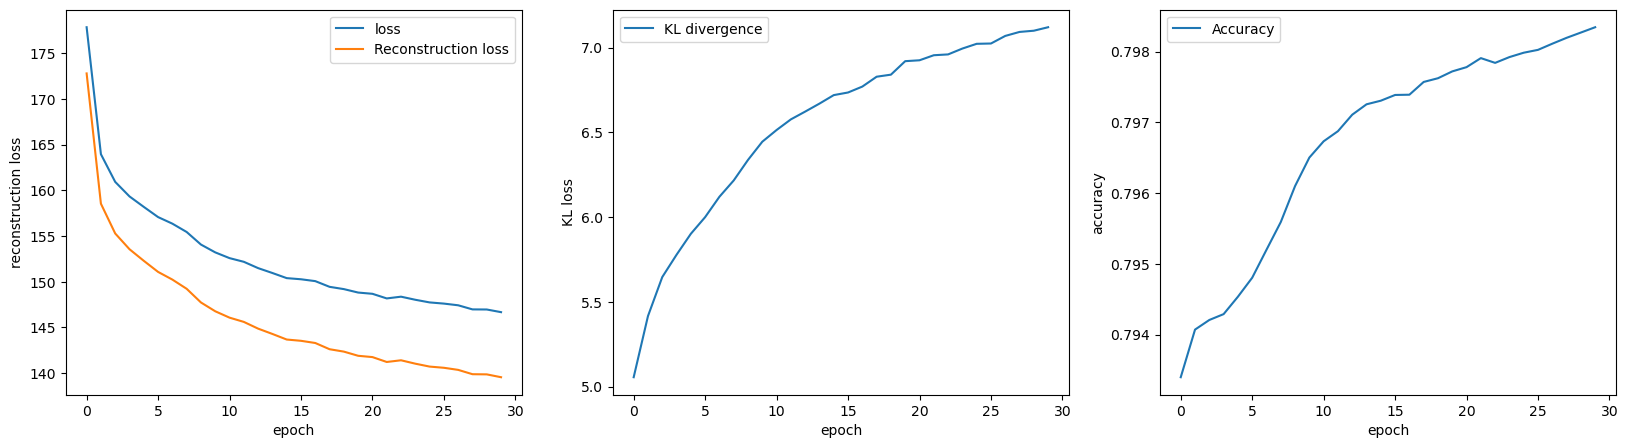

In [10]:
f, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
ax[0].set_ylabel('reconstruction loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['kl_loss_metric'], label = 'KL divergence')
ax[1].set_ylabel('KL loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].plot(history.history['accuracy'], label = 'Accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend()

plt.show()

The three loss curves plotted in cell 16 are:

1. Reconstruction loss: This curve shows the reconstruction loss of the VAE model during training. The reconstruction loss measures the difference between the input image and the output image generated by the decoder. The goal of the VAE is to minimize this loss, which means that the generated images should be as close as possible to the input images.

2. KL divergence: This curve shows the KL divergence between the posterior distribution and the prior distribution during training. The KL divergence measures the difference between these two distributions. The goal of the VAE is to minimize this loss, which means that the posterior distribution should be as close as possible to the prior distribution.

3. Accuracy: This curve shows the accuracy of the VAE model during training. The accuracy measures how well the model is able to classify the input images. In the case of the VAE, the accuracy is not the main objective, but it can be used to evaluate the performance of the model.

### Prediction of test data (plot 2)

313/313 [==============================] - 8s 20ms/step


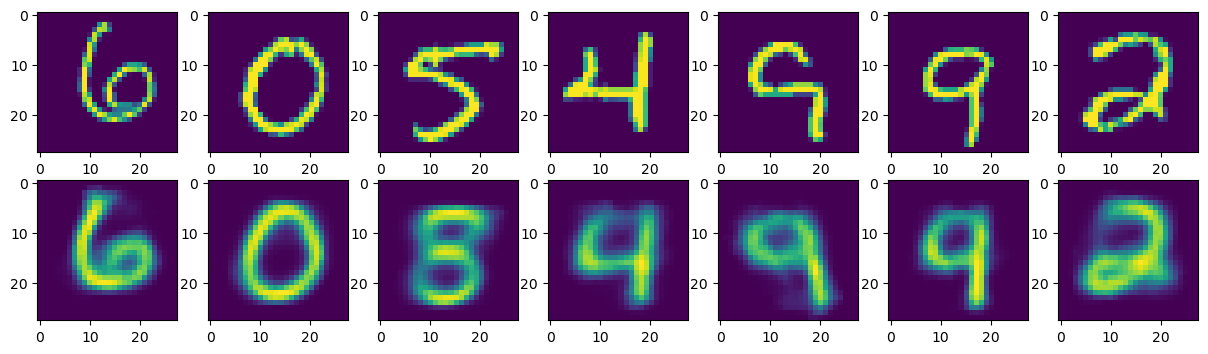

In [11]:
predict = autoencoder.predict(x_test/255.)
f, ax = plt.subplots(2, 7, figsize = (15,4))

# Testing the reconstruction quality of the network using the Test Images 
for i in range(7):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(predict[i+100,:,:,0])

### Testing the generative quality of the network (plot 3)

1/1 [==============================] - 0s 62ms/step


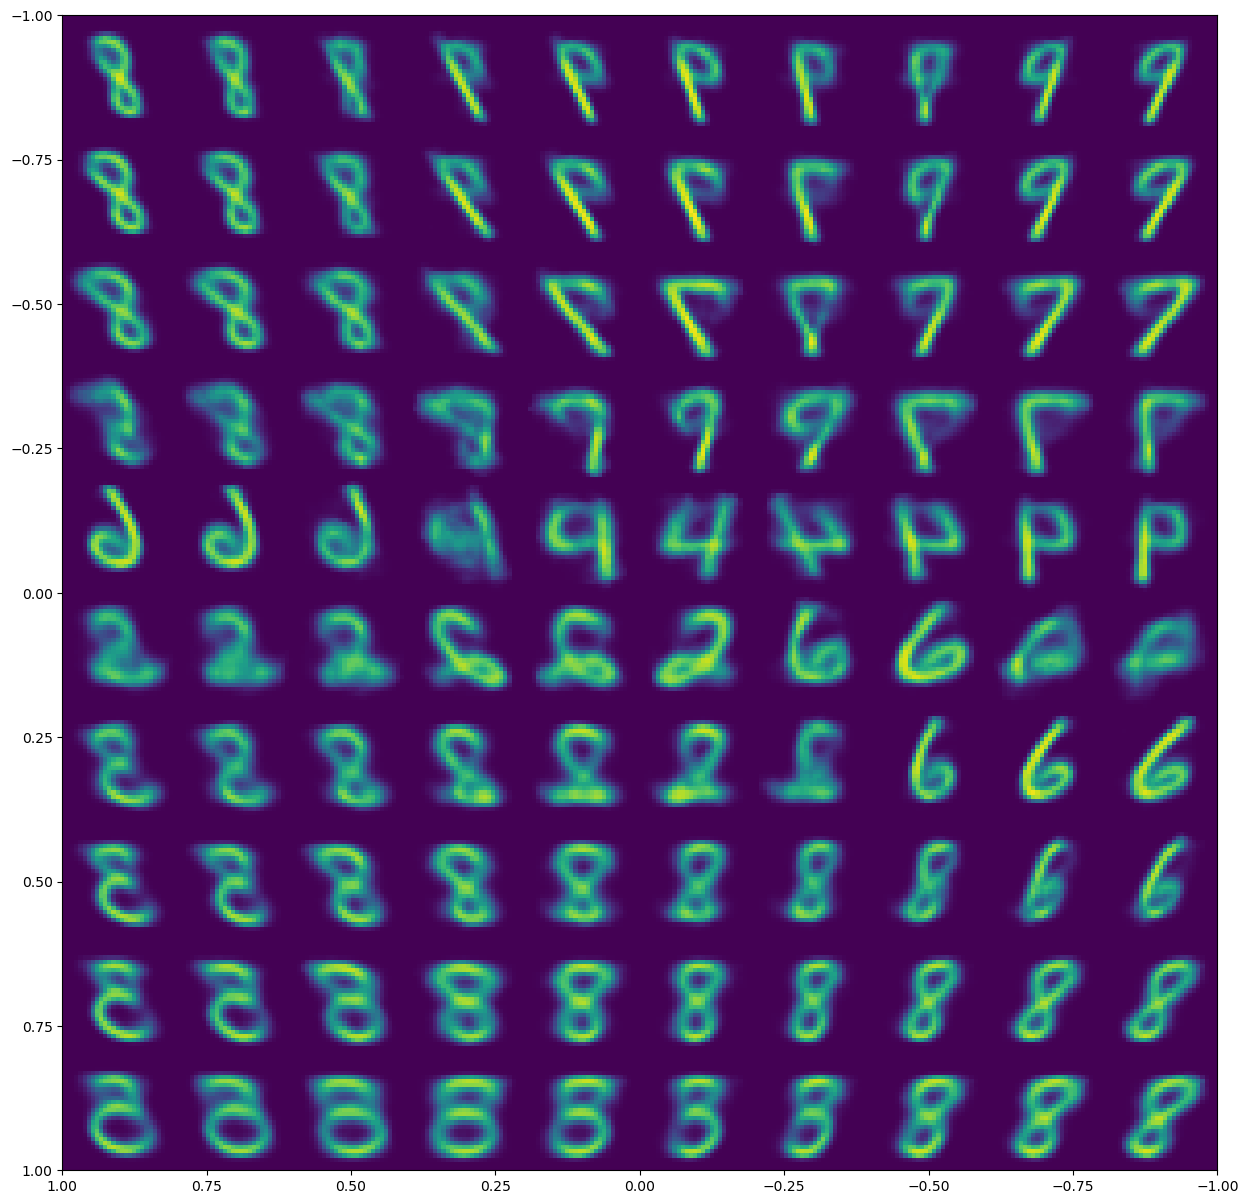

In [12]:
x_axis = np.linspace(-1, 1, 10)
y_axis = np.linspace(-1, 1, 10)
figure = np.zeros((28 * 10, 28 * 10))

# loop through each number for decoding
for i_x, x in enumerate(x_axis):
    for i_y, y in enumerate(y_axis):
        latent = np.array([[x, y]])
        #print(latent)
        generated_image = decoder.predict(latent)[0] # decode the numbers
        figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]

plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[1,-1,1,-1])
plt.show()

### Task: Visualize the latent space (if latent_dim > 2 then by using T_SNE) (plot 4)
#### Describe the latent space with respect to its structure. 

Remember: t-SNE is stochastic and therefore the results may appear slightly different every time it is re-run. So don't worry.


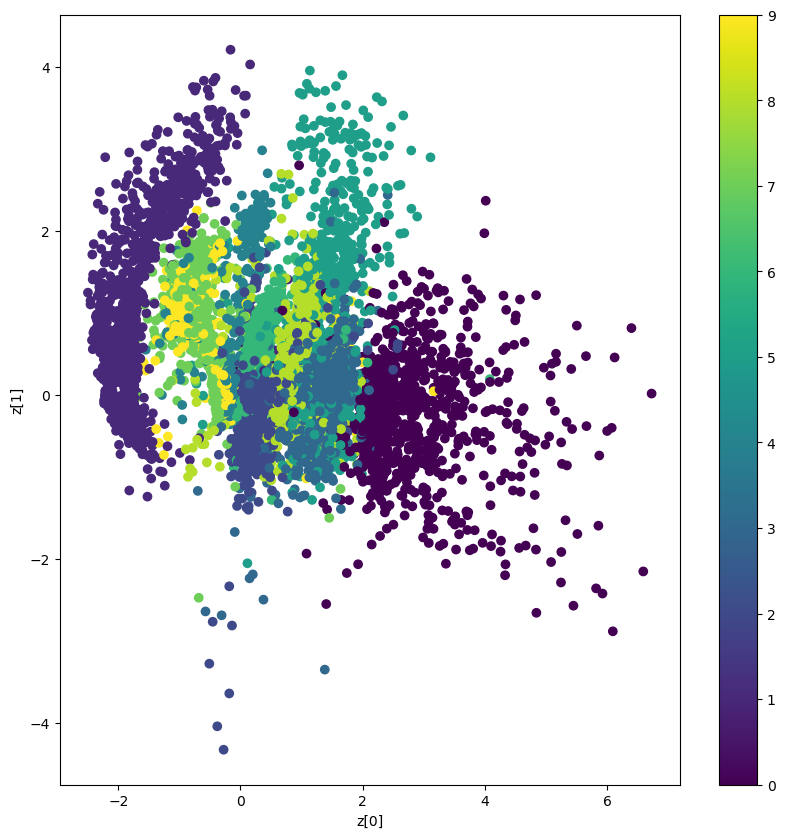

In [15]:
from sklearn.manifold import TSNE
# add your code section here !

# Get the latent space representation of the test data
z_mean, _ = autoencoder.encode(x_test/255.)

# If the latent dimension is greater than 2, reduce it to 2 dimensions using T-SNE
if z_mean.shape[1] > 2:
    z_mean = TSNE(n_components=2).fit_transform(z_mean)

# Plot the latent space
plt.figure(figsize=(10, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis') # that line did is sliced the array, taking all rows (:) but keeping the second column (1)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

# The latent space structure is visualized using a scatter plot where each point represents a data sample from the test set. 
# The color of each point represents the true label of the corresponding data sample. 
# The plot shows that the latent space has a clear separation between different classes, indicating that the VAE has learned a good representation of the data.
# The plot also shows that the latent space is continuous, meaning that similar data samples are located close to each other in the latent space. 
# This is expected since the VAE is a generative model that learns to generate new data samples by sampling from the latent space.